# Homodimerization and Annihilation

This is for an integrated test of E-Cell4. Here, we test homodimerization and annihilation.

In [1]:
%matplotlib inline
import numpy
from ecell4 import *
from ecell4.extra.ensemble import ensemble_simulations
from ecell4_base.core import GSLRandomNumberGenerator, Integer3

Parameters are given as follows. `D`, `radius`, `N_A`, and `ka_factor` mean a diffusion constant, a radius of molecules, an initial number of molecules of `A`, and a ratio between an intrinsic association rate and collision rate defined as `ka` and`kD` below, respectively. Dimensions of length and time are assumed to be micro-meter and second.

In [2]:
D = 1
radius = 0.005
N_A = 60
ka_factor = 0.1  # 0.1 is for reaction-limited

In [3]:
N = 30  # a number of samples
rng = GSLRandomNumberGenerator()
rng.seed(0)

Calculating optimal reaction rates. `ka` is intrinsic, `kon` is effective reaction rates. Be careful about the calculation of a effective rate for homo-dimerization. An intrinsic must be halved in the formula. This kind of parameter modification is not automatically done.

In [4]:
kD = 4 * numpy.pi * (radius * 2) * (D * 2)
ka = kD * ka_factor
kon = ka * kD / (ka + kD)

Start with `A` molecules, and simulate 3 seconds.

In [5]:
y0 = {'A': N_A}
duration = 3
T = numpy.linspace(0, duration, 21)
opt_kwargs = {'xlim': (T.min(), T.max()), 'ylim': (0, N_A)}

Make a model with an effective rate. This model is for macroscopic simulation algorithms.

In [6]:
with species_attributes():
    A | {'radius': radius, 'D': D}

with reaction_rules():
    A + A > ~A2 | kon * 0.5

m = get_model()

Save a result with `ode` as `obs`, and plot it:

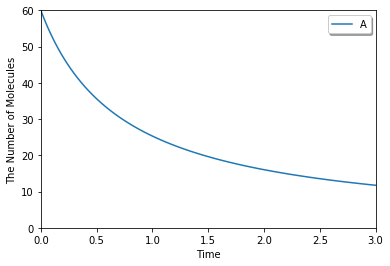

In [7]:
obs = run_simulation(numpy.linspace(0, duration, 101), y0, model=m, return_type='observer',
                     solver='ode')
viz.plot_number_observer(obs, **opt_kwargs)

Simulating with `gillespie`:

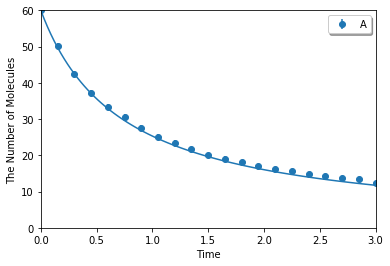

In [8]:
ensemble_simulations(T, y0, model=m, opt_args=('o', obs, '-'), opt_kwargs=opt_kwargs,
                     solver='gillespie', n=N)

Simulating with `meso`:

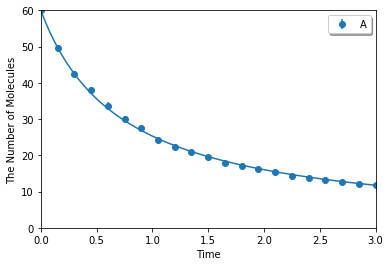

In [9]:
ensemble_simulations(T, y0, model=m, opt_args=('o', obs, '-'), opt_kwargs=opt_kwargs,
                     solver=('meso', Integer3(1, 1, 1), 0.25), n=N)

Make a model with an intrinsic rate. This model is for microscopic (particle) simulation algorithms.

In [10]:
with species_attributes():
    A | {'radius': radius, 'D': D}

with reaction_rules():
    A + A > ~A2 | ka

m = get_model()

Simulating with `spatiocyte`:

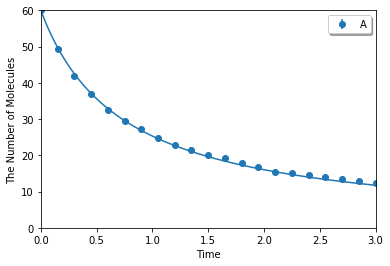

In [11]:
ensemble_simulations(T, y0, model=m, opt_args=('o', obs, '-'), opt_kwargs=opt_kwargs,
                     solver=('spatiocyte', radius), n=N)

Simulating with `egfrd`:

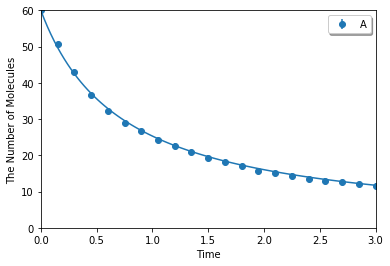

In [12]:
ensemble_simulations(T, y0, model=m, opt_args=('o', obs, '-'), opt_kwargs=opt_kwargs,
                     solver=('egfrd', Integer3(4, 4, 4)), n=N)